In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')


In [278]:
mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m']

mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m']

mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m']

In [45]:
from scipy.special import

In [269]:
def CIR_path(r0, days, theta, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    theta = theta
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a * (theta - r[t-1]) * dt + vol * rand[t] * np.sqrt(dt * r[t - 1])
    CIR = pd.DataFrame(r[:, 0], columns=['index'])
    CIR = CIR.values.flatten()
    return CIR


def CIR_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated CIR Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(CIR_path(data[0], len(data), opt[0], opt[1],
                      opt[2]), lw=0.8, alpha=alpha)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()
    
def CIR_ml_final_diff(p0, penalty=np.inf):
    theta, a, vol = p0
    if theta <= 0 or vol <= 0 or a <= 0 :
        return penalty 
    x = data.values
    dx = np.diff(data.values)
    dt = np.array([1/252]*len(dx))
    dt = np.array([1]*len(dx))
    
    c = 2 * a / (1 - np.exp( - a * dt)) / vol**2
    q = 2 * theta * a / vol - 1
    u =  c * x[:-1] * np.exp( - a * dt)
    v =  c * x[1:]
    
    f = np.zeros(len(dx))
    for i in range(len(dx)):
        f[i] = np.log(c[i]) + ( - u[i] - v[i]) + q * np.log(v[i]/ u[i]) + np.log( iv(q, 2 * np.sqrt(u[i] * v[i])))
        #print(c[0], u[i], v[i], q, np.log(c[i]), ( - u[i] - v[i]), q * np.log(v[i]/ u[i]), 2 * np.sqrt(u[i] * v[i]), iv(q, 2 * np.sqrt(u[i] * v[i])))
    L = - np.sum(f)
    if L == -np.inf:
        return penalty
    #print(L)
    return L


def CIR_ml_final_diff(p0, penalty=np.inf):
    theta, a, vol = p0
    if theta <= 0 or vol <= 0 or a <= 0 :
        return penalty 
    x = data.values
    dx = np.diff(data.values)
    dt = np.array([1/252]*len(dx))
    #dt = np.array([1]*len(dx))
    
    mu = a * (theta - x[:-1]) * dt 
    sigma = vol * np.sqrt(dt * x[:-1])
    
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [282]:
def mean_max_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        pathes =  CIR_path(data[0], len(data), opt[0], opt[1], opt[2])
        dist.append(np.max(np.abs(pathes - data)))
    return np.mean(dist)

In [370]:
data = mosprime3m_between

In [373]:
data = data.iloc[420:]

In [374]:
p1 = np.array([0.01, 0.01, 0.01])
p2 = np.array([0.1,  0.1, 0.1])
p3 = np.array([np.median(data),  max(data) - min(data) , np.sqrt(data.var())])
p4 = np.array([40, 2, 1])

Optimization terminated successfully.
         Current function value: -646.795507
         Iterations: 77
         Function evaluations: 137
[ 7.19951024  2.86282749  0.19588284]
0.714671183082


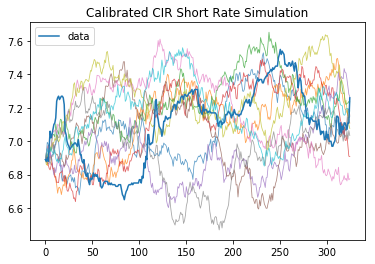

In [375]:
CIR_ml_ex1 = sop.fmin(CIR_ml_final_diff, p3,
               maxiter=10000, maxfun=10000, xtol=0.001, ftol=0.001)

print(CIR_ml_ex1)
print(mean_max_dist(CIR_ml_ex1, data, num_paths=10))
CIR_p(data, CIR_ml_ex1, num_paths=10)

In [376]:
def mean_max_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        dist.append(np.max(np.abs(data - CIR_path(data[0], len(data), opt[0], opt[1], opt[2]))))
    return np.mean(dist)

def opt_mean_max_dist(p0):
    return mean_max_dist(p0, data, num_paths=100)

[ 7.3155034   0.93623937  0.21377875]
0.889964335345


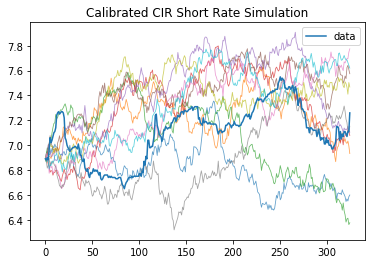

In [377]:
CIR_dist_ex1 = sop.fmin(opt_mean_max_dist, p3,
               maxiter=100, maxfun=100, xtol=0.01, ftol=0.01)

print(CIR_dist_ex1)
print(mean_max_dist(CIR_dist_ex1, data, num_paths=10))
CIR_p(data, CIR_dist_ex1, num_paths=10)

In [378]:
def mean_sum_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        dist.append(np.sum(np.abs(data - CIR_path(data[0], len(data), opt[0], opt[1], opt[2]))))
    return np.max(dist)

def opt_mean_sum_dist(p0):
    return mean_sum_dist(p0, data, num_paths=10)

[ 7.16537786  0.91810931  0.22234776]
180.045274193


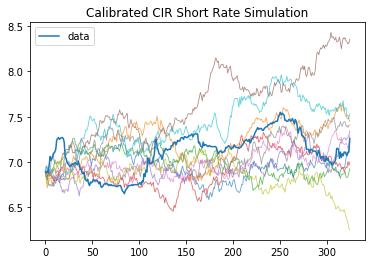

In [379]:
CIR_dist_sum_ex1 = sop.fmin(opt_mean_sum_dist, p3,
               maxiter=100, maxfun=100, xtol=0.1, ftol=0.1)

print(CIR_dist_sum_ex1)
print(mean_sum_dist(CIR_dist_sum_ex1, data, num_paths=10))
CIR_p(data, CIR_dist_sum_ex1, num_paths=10)